<a href="https://colab.research.google.com/github/toby-j/COM3025-CW/blob/main/initial_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow

In [2]:
def output_metrics(model, test_data, test_labels):
  predictions = model.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)
  y_test = np.argmax(test_labels, axis=-1)

  print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
  print(f'F1 score: {f1_score(y_test, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(y_test, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(y_test, y_pred, average="weighted")}')

In [3]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [4]:
!pip install -q kaggle
from google.colab import files 

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plastictrees","key":"e4da464bc9f316b32dbb185235a328e7"}'}

In [6]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [00:37<00:00, 169MB/s]
100% 5.20G/5.20G [00:37<00:00, 150MB/s]


In [10]:
!unzip skin-cancer-mnist-ham10000.zip -d content

Streaming output truncated to the last 5000 lines.
  inflating: content/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: content/ham10000_images_part_2/ISIC_0029339.jpg  
  in

In [11]:
# Removing the zip to save space
!rm skin-cancer-mnist-ham10000.zip

In [12]:
df = pd.read_csv('content/HAM10000_metadata.csv')

In [13]:
print(df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


In [14]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [15]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [16]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
raw_images = 'content'

In [17]:
from glob import glob

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(raw_images, '*', '*.jpg'))}

In [18]:
print(os.path.join(raw_images, '*', '*.jpg'))

content/*/*.jpg


In [19]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [20]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [21]:
df['age'].mean()

51.863828077927295

In [22]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,content/ham10000_images_part_1/ISIC_0027419.jpg,Bening keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,content/ham10000_images_part_1/ISIC_0025030.jpg,Bening keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,content/ham10000_images_part_1/ISIC_0026769.jpg,Bening keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,content/ham10000_images_part_1/ISIC_0025661.jpg,Bening keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,content/ham10000_images_part_2/ISIC_0031633.jpg,Bening keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,content/ham10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,content/ham10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,content/ham10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,content/ham10000_images_part_2/ISIC_0032854.jpg,Actinic keratoses,0


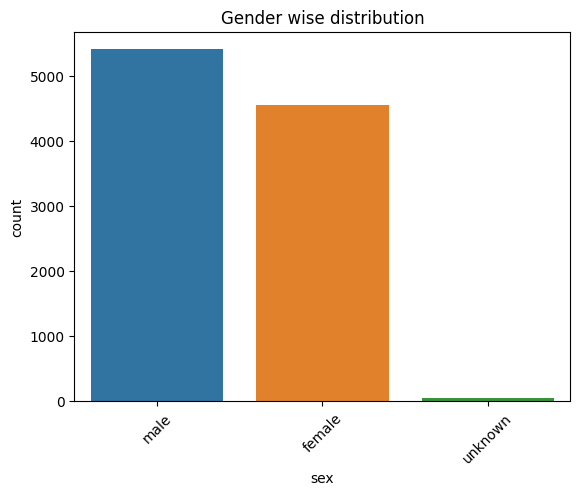

In [23]:
ax = sns.countplot(x = 'sex', data = df)
plt.title('Gender wise distribution')
plt.xticks(rotation=45)
plt.show()

In [24]:
df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

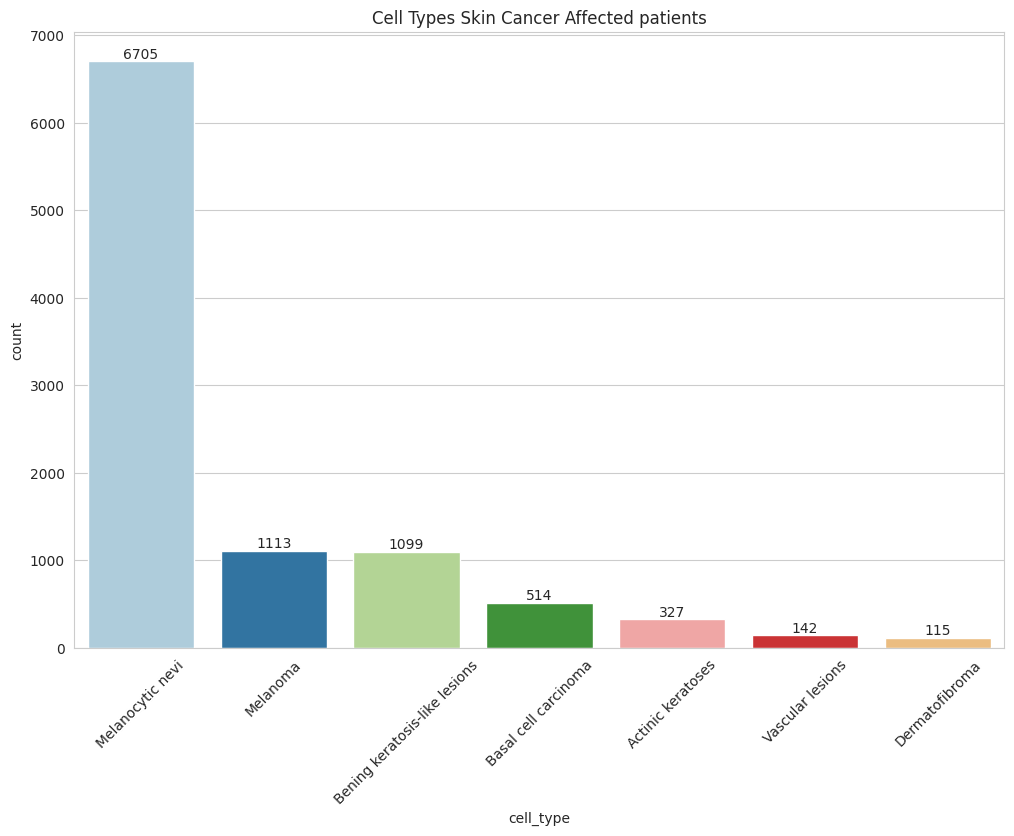

In [25]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

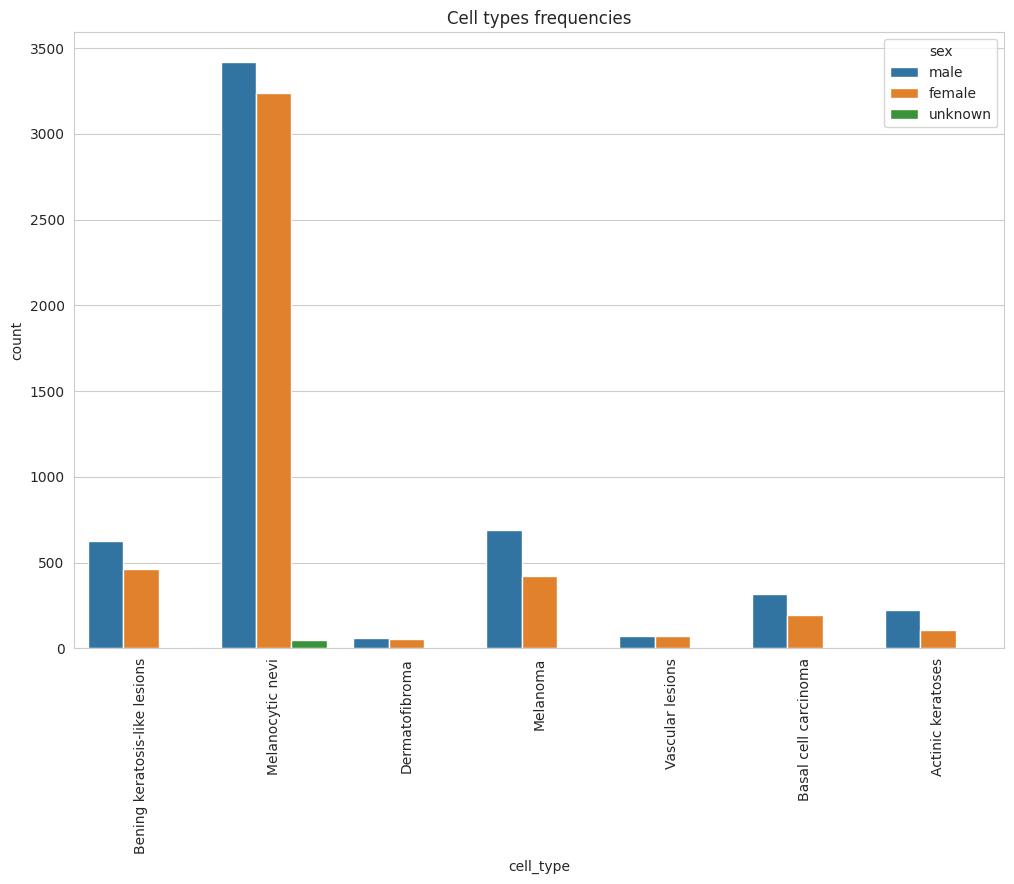

In [26]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type', hue='sex', data = df)
plt.title('Cell types frequencies')
plt.xticks(rotation=90)
plt.show()

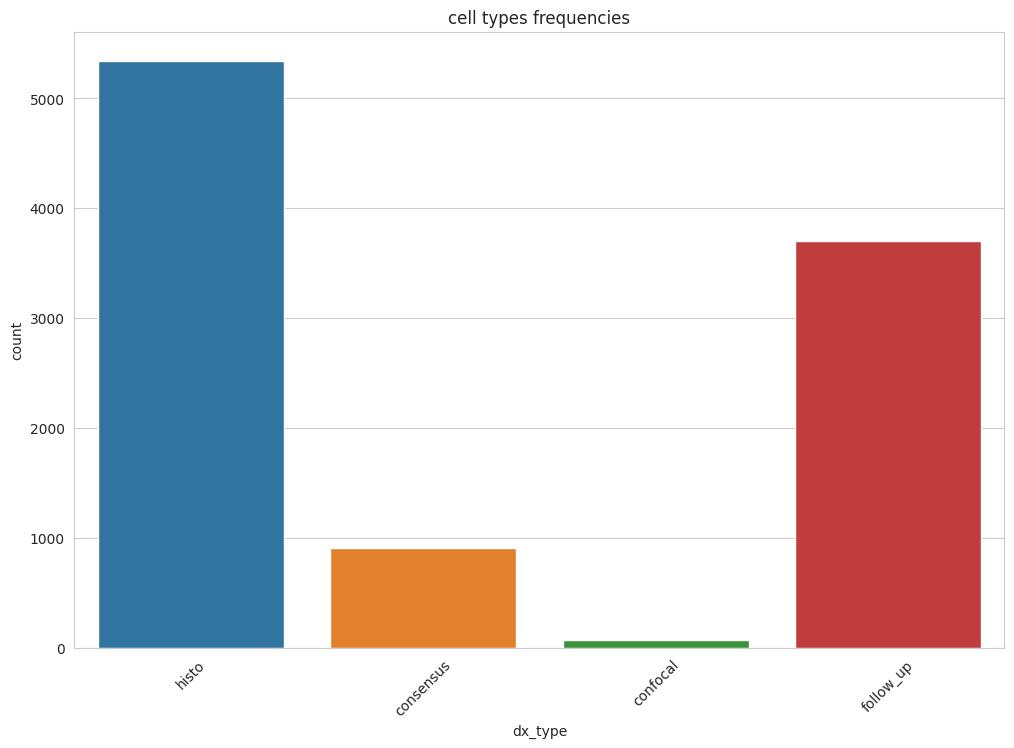

In [27]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', data=df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

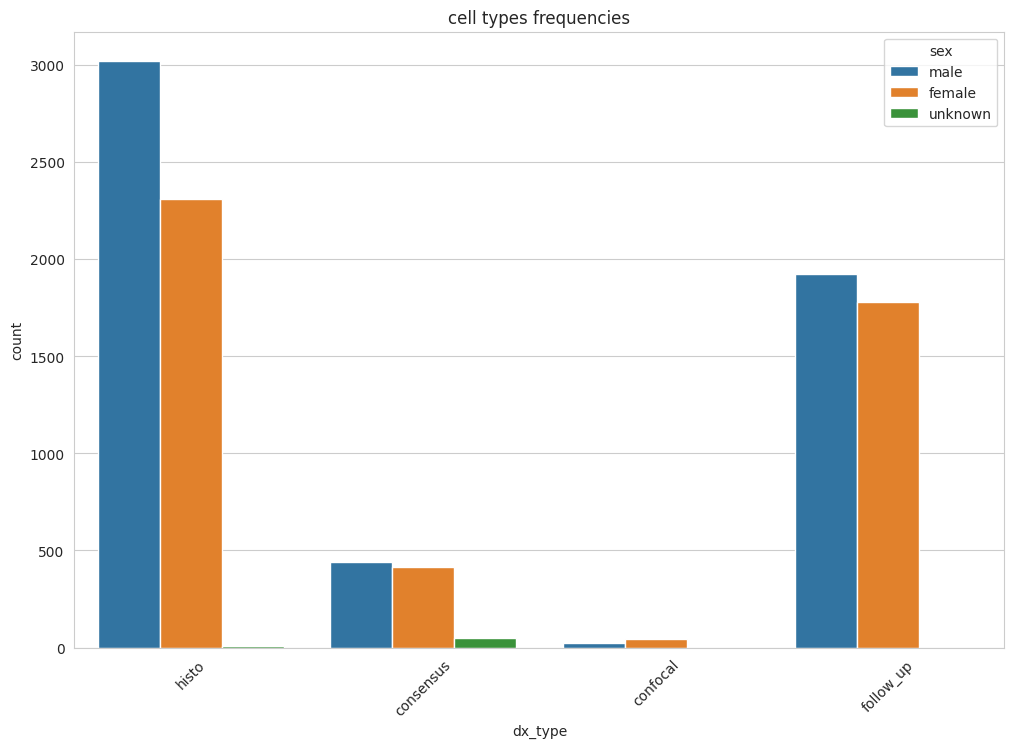

In [28]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', hue = 'sex', data = df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

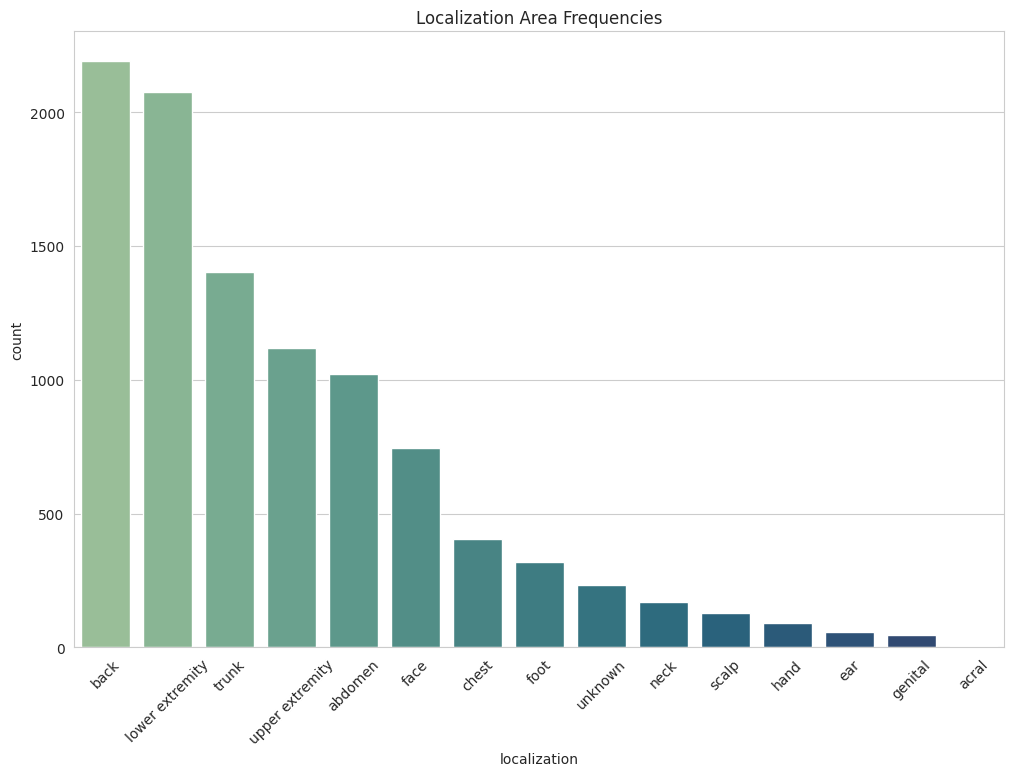

In [29]:
sns.set_style('whitegrid')
fig,axis = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization', data=df, order=df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

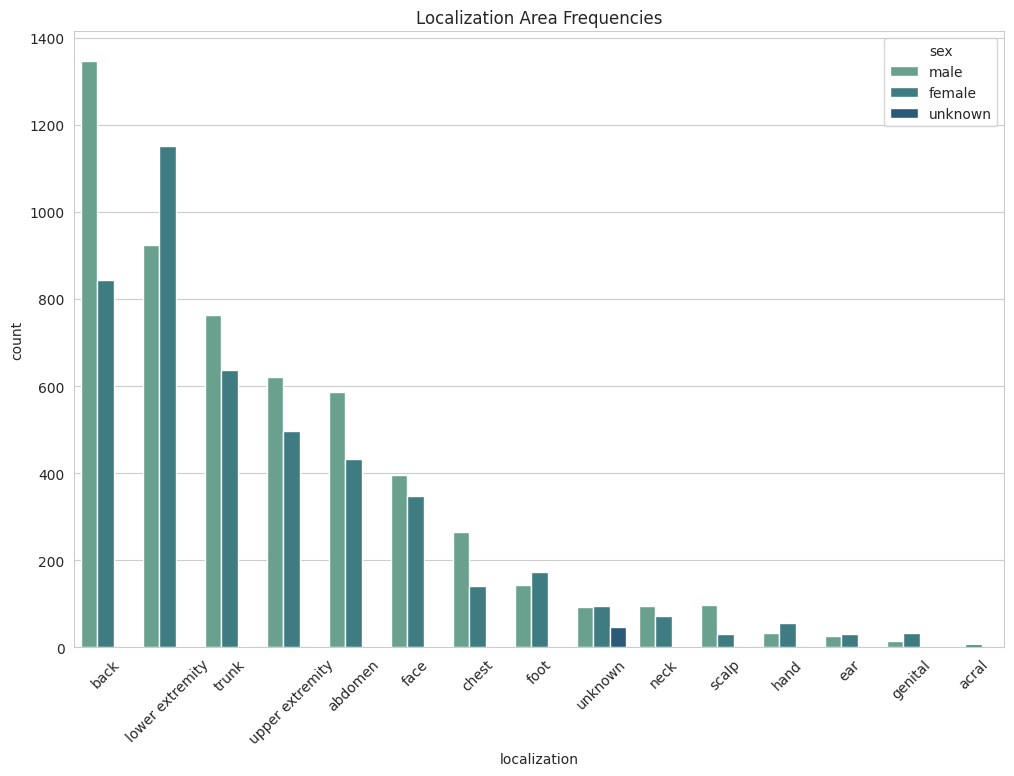

In [30]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'localization', hue = 'sex', data = df, order = df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

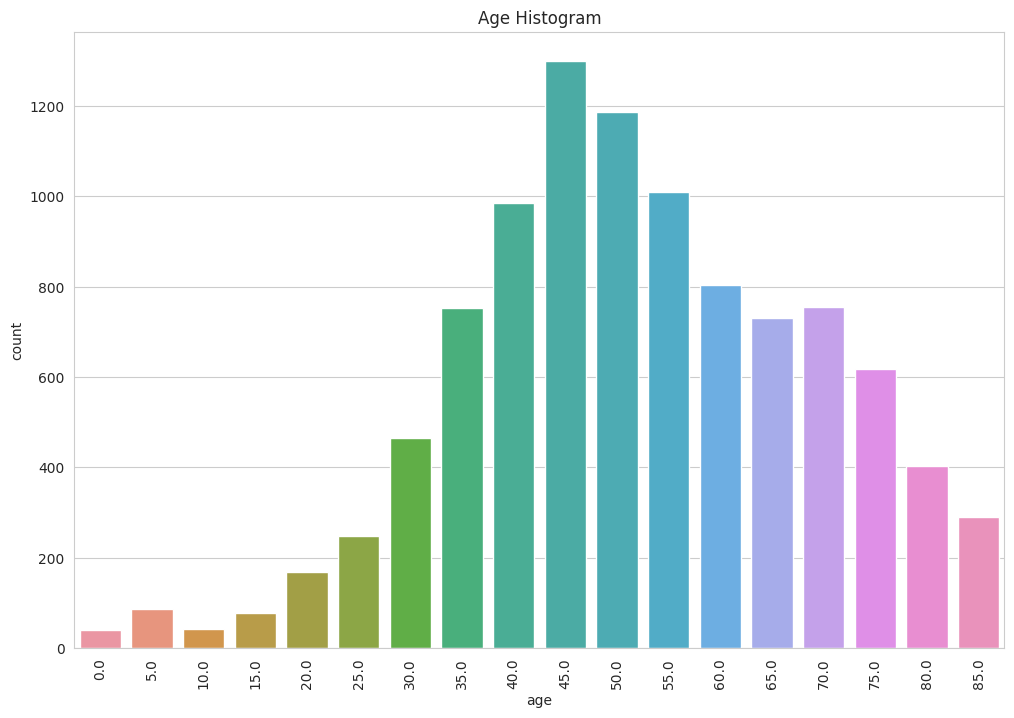

In [31]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'age', data = df)
plt.title('Age Histogram')
plt.xticks(rotation=90)
plt.show()

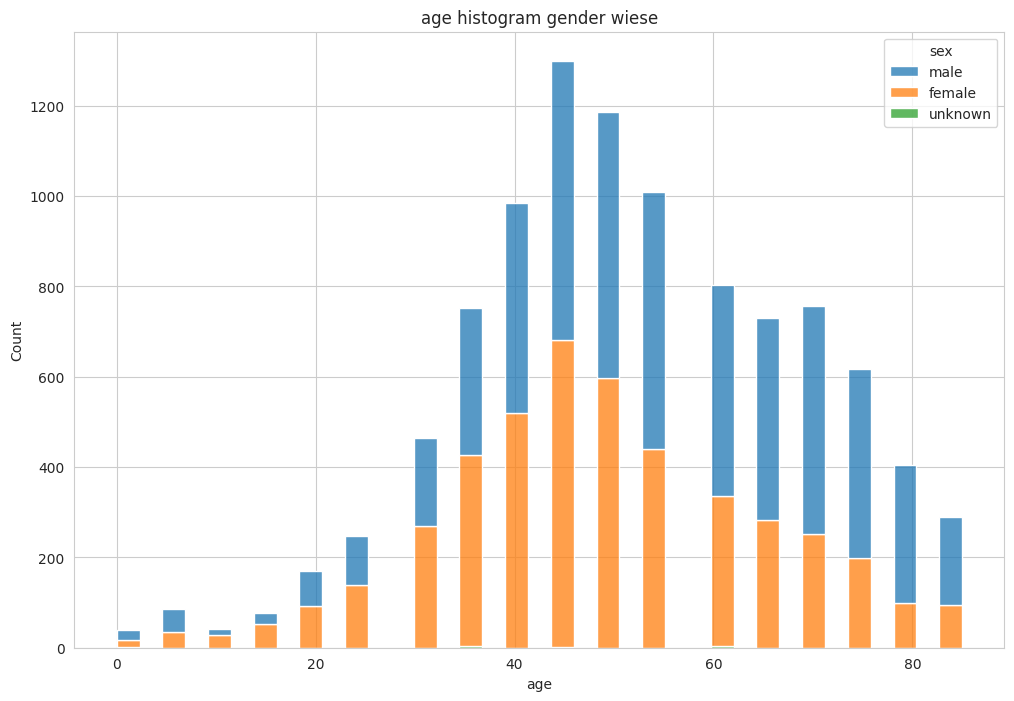

In [32]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x = 'age', hue = 'sex', multiple='stack')
plt.title('age histogram gender wiese')
plt.show()


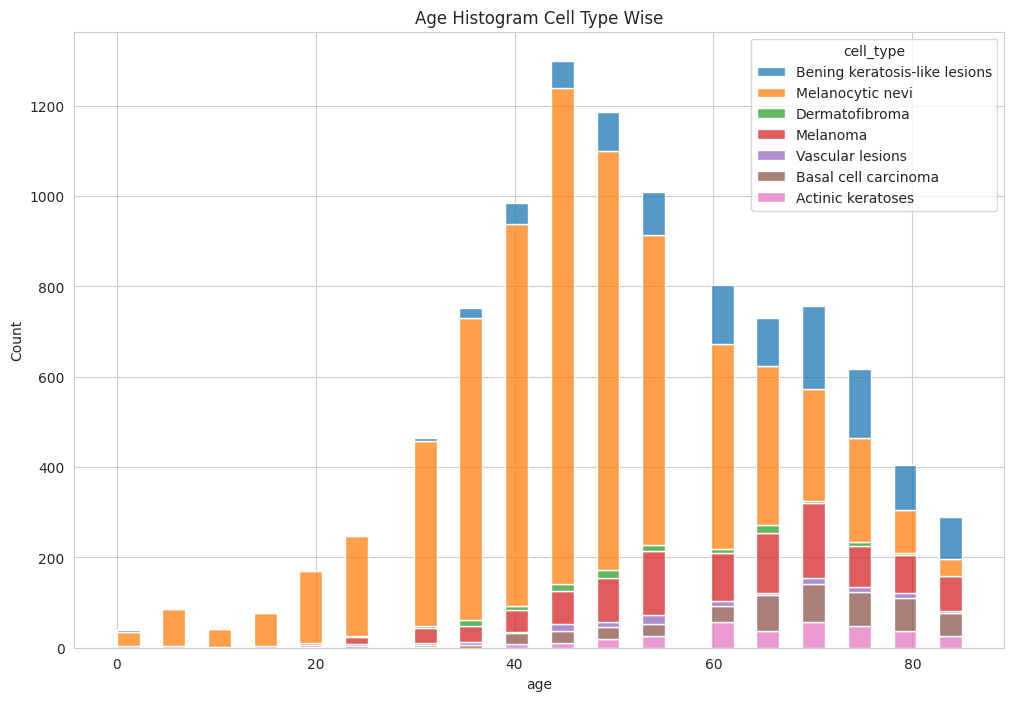

In [33]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

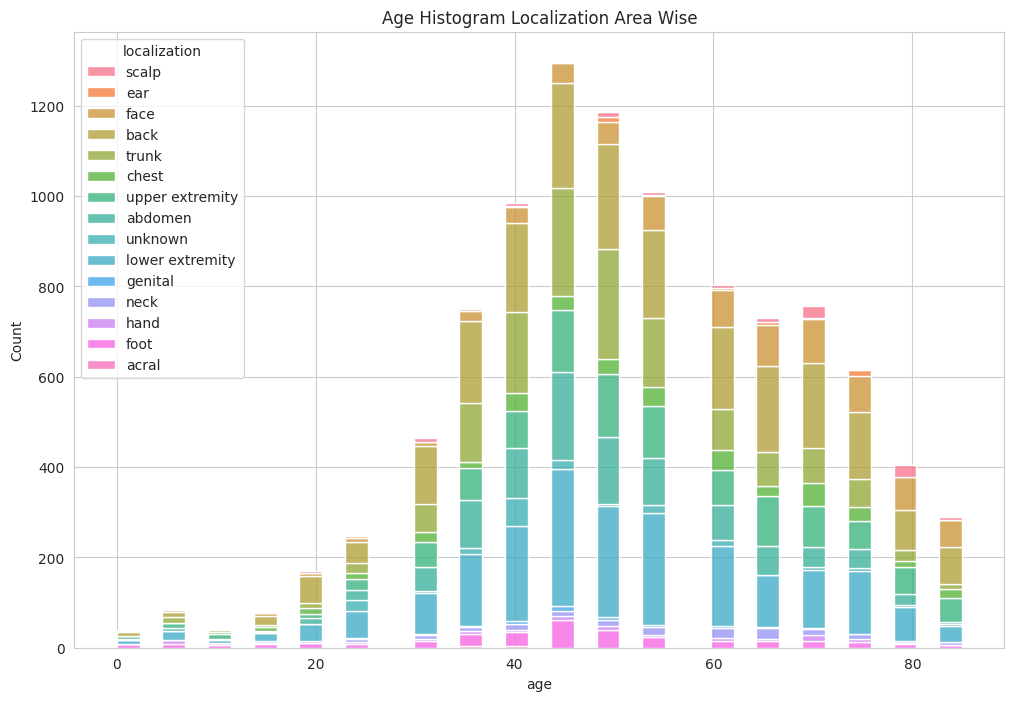

In [34]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

In [35]:
# Function to read and resize images
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [36]:
image_size = (64, 64)

In [37]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

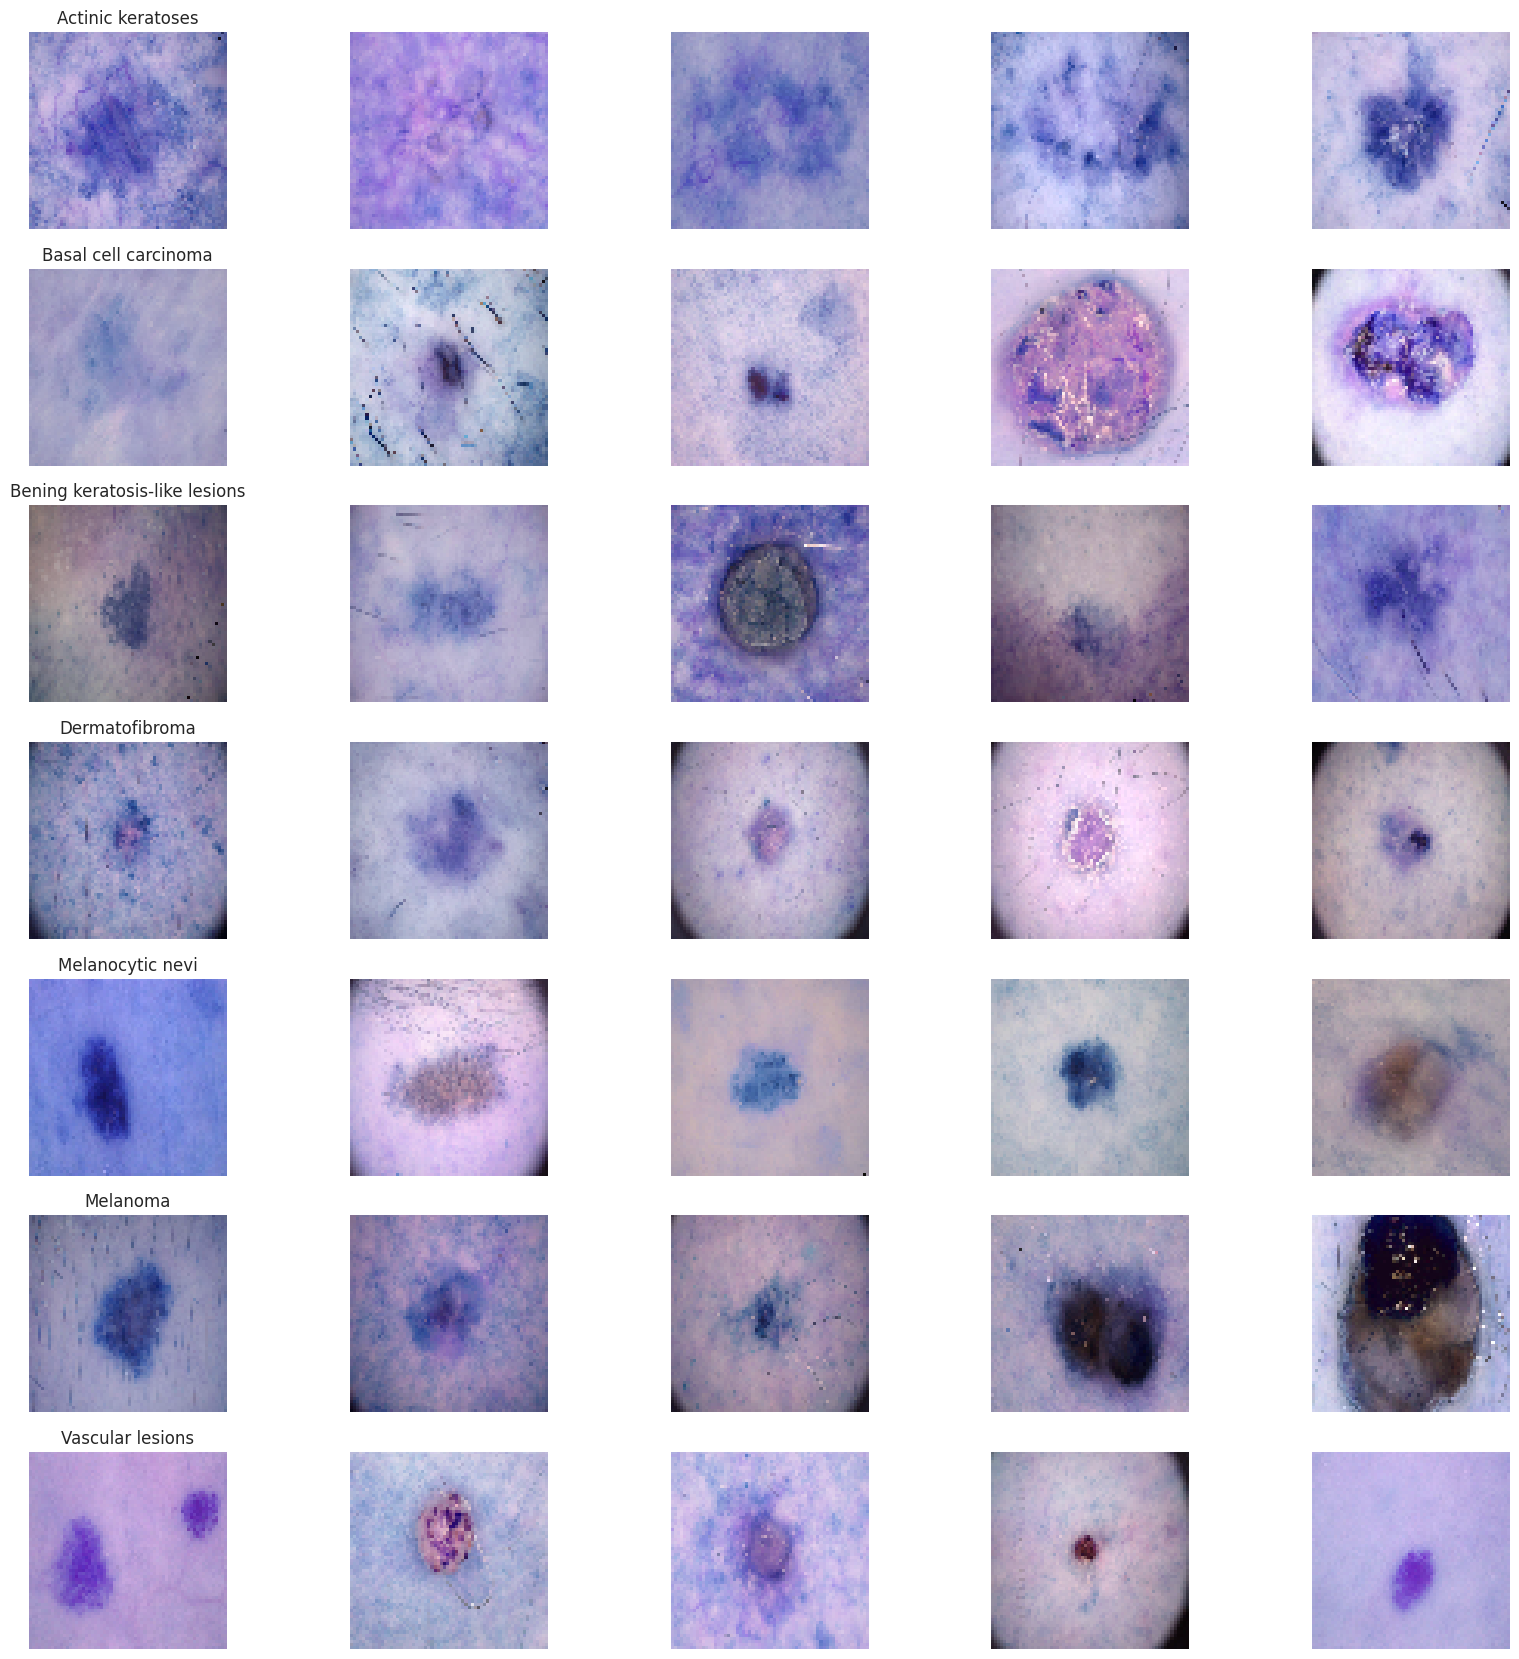

In [38]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [39]:
df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [41]:
# Extract the image data and target labels for train and test sets
X_train = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [42]:
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import Sequential
import tensorflow

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))

In [43]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.fit(X_train, y_train, batch_size=256, epochs=30, validation_split=0.4)

Epoch 1/30
19/19 [==============================] - 2s 73ms/step - loss: 0.7269 - accuracy: 0.7333 - val_loss: 0.9708 - val_accuracy: 0.6814
Epoch 2/30
19/19 [==============================] - 1s 58ms/step - loss: 0.6946 - accuracy: 0.7404 - val_loss: 0.9777 - val_accuracy: 0.6942
Epoch 3/30
19/19 [==============================] - 1s 34ms/step - loss: 0.6840 - accuracy: 0.7470 - val_loss: 0.9724 - val_accuracy: 0.6920
Epoch 4/30
19/19 [==============================] - 1s 37ms/step - loss: 0.6675 - accuracy: 0.7566 - val_loss: 0.9893 - val_accuracy: 0.6889
Epoch 5/30
19/19 [==============================] - 1s 37ms/step - loss: 0.6537 - accuracy: 0.7556 - val_loss: 1.0016 - val_accuracy: 0.6914
Epoch 6/30
19/19 [==============================] - 1s 34ms/step - loss: 0.6339 - accuracy: 0.7683 - val_loss: 1.0016 - val_accuracy: 0.6933
Epoch 7/30
19/19 [==============================] - 1s 34ms/step - loss: 0.6242 - accuracy: 0.7712 - val_loss: 0.9951 - val_accuracy: 0.6895
Epoch 8/30
19

In [47]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the accuracy
accuracy = np.mean(y_pred_classes == y_test) * 100
print(f'Test accuracy: {accuracy:.2f}%')

63/63 [==============================] - 0s 3ms/step
Test accuracy: 67.40%
